## 이미지 분류 (EfficientNet)

- anomal | normal : 1236 | 9855
- anomal data proportion(train:valid:test) =  984 : 123 : 129
- nomal data proportion(train:valid:test) = 7880 : 985 : 990
- data proportion(train:valid:test) = 8864 : 1108 : 1119

220106

In [1]:
## load library
import numpy as np
import json
from PIL import Image
import PIL.Image as pilimg
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from sklearn.metrics import f1_score
from tqdm import tqdm

In [2]:
## parameter
is_Test = False
# is_Test = True
num_epochs = 25
batch_size  = 128

data_path = 'data_220104_split'
save_path='output'

In [3]:
## prepare data
## make dataset
from torchvision import transforms, datasets
from torch.utils.data import Subset, dataloader
# class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
data_train_path = os.path.join(data_path, 'train')
data_valid_path = os.path.join(data_path, 'valid')
data_test_path  = os.path.join(data_path, 'test')

# 이미지 tensor형태로 변환
transform_function = transforms.Compose([
    transforms.Resize((224, 224)),  # 모델 입력사이즈로 resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = {}
dataset['train'] = datasets.ImageFolder(data_train_path, 
                                        transform_function)
dataset['valid'] = datasets.ImageFolder(data_valid_path,
                                        transform_function)
dataset['test'] = datasets.ImageFolder(data_test_path,
                                        transform_function)
print('data proportion(train:valid:test) = %s : %s : %s'%(len(dataset['train']), len(dataset['valid']), len(dataset['test'])))


data proportion(train:valid:test) = 8864 : 1108 : 1119


In [4]:
## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset['train'],
                                              batch_size=batch_size, shuffle=True,
                                              num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(dataset['valid'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(dataset['test'],
                                              batch_size=batch_size, shuffle=False,
                                              num_workers=4)
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  number of batch(tvt) : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 128,  number of batch(tvt) : 70 / 9 / 9


# For training

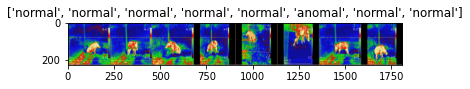

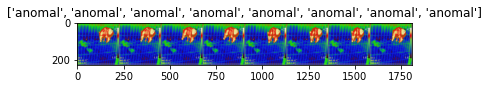

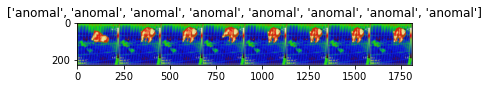

In [5]:
## 데이타 체크
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

num_show_img = 8

class_names = {
    "0": "anomal",  # "0": "비정상"
    "1": "normal",  # "1": "정상"
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])
# test check
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:num_show_img])  # batch의 이미지를 오려부친다
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_show_img]])

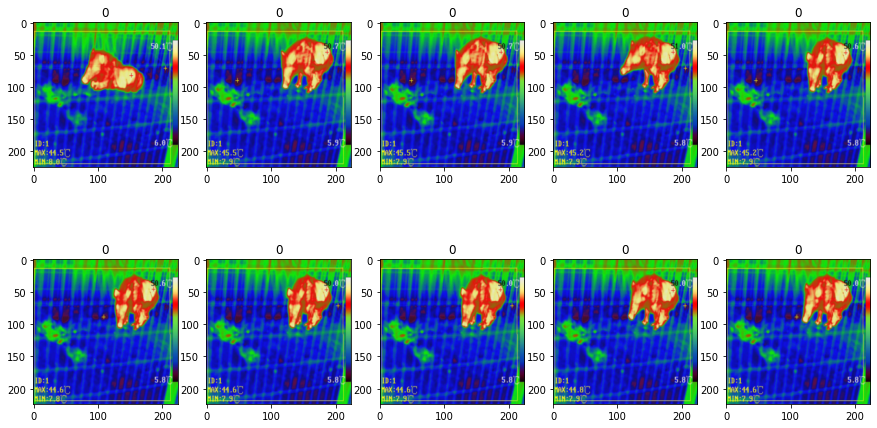

In [6]:
## batch의 tensor 이미지를 확인하기 위한 함수
def check_image_from_tensor(check_image, check_class):
    title = list(check_class.cpu().numpy())  # torch tensor to list
    
    # 5x1 형식으로 만들기 위해
    num_image = len(title)
    if num_image <= 5:
        columns = num_image
        rows = 1
    else:
        columns = 5
        rows = int(np.ceil(num_image/columns))

    fig=plt.figure(figsize=(3*columns, 4*rows))

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    for i in range(1, num_image +1):
        inp = check_image[i-1].numpy().transpose((1, 2, 0))
        inp = std * inp + mean  # 원본 이미지로 변환
        inp = np.clip(inp, 0, 1)
        
        fig.add_subplot(rows, columns, i)
        plt.title(title[i-1])
        plt.imshow(inp)
    plt.show()


num_show_img = 10
# data check
inputs, classes = next(iter(dataloaders['test']))
check_image, check_class = inputs[:num_show_img], classes[:num_show_img]
check_image_from_tensor(check_image, check_class)

In [7]:
## load model
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b0'  # b5
num_classes = 2  # 장싱, 비정상
freeze_extractor = True  # FC layer만 학습하고 efficientNet extractor 부분은 freeze하여 학습시간 단축, 89860 vs 4097408
use_multi_gpu = True

image_size = EfficientNet.get_image_size(model_name)
print('model input shape : (%d x %d)'%(image_size, image_size))
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)

# fc 제외하고 freeze
if freeze_extractor:
    print('extractor freeze')
    for n, p in model.named_parameters():
        if '_fc' not in n:
            p.requires_grad = False
            

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)            
print('학습 parameters 개수 : %d'%(count_parameters(model)))
            
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# multi gpu(2개 이상)를 사용하는 경우
if use_multi_gpu:
    num_gpu = torch.cuda.device_count()
    if (device.type=='cuda') and (num_gpu > 1):
        print('use multi gpu : %d' % (num_gpu))
        model = nn.DataParallel(model, device_ids=list(range(num_gpu)))
        
model = model.to(device)

model input shape : (224 x 224)
Loaded pretrained weights for efficientnet-b0
extractor freeze
학습 parameters 개수 : 2562
use multi gpu : 2


In [8]:
# define optimizer, criterion
criterion = nn.CrossEntropyLoss()  # 분류이므로 cross entrophy 사용

# optimizer 선언, SGD, Adam으로도 해보자
# optimizer = optim.SGD(model.parameters(), 
#                          lr = 0.05,
#                          momentum=0.9,
#                          weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.98739)  # LR 스케쥴러, 점점 줄어든다

In [9]:
# define trainer
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, is_test=False, save_path='output'):
    since = time.time()

    if not os.path.isdir(save_path):  os.makedirs(save_path)  # 저장 폴더 생성
    # for saving best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc, best_f1 = 0.0, 0.0
    train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1 = [], [], [], [], [], []

    for epoch in range(num_epochs):
        print('\nEpoch %d/%d' % (epoch, num_epochs-1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            pred_list, label_list = [], []  
            # Iterate over data
#             for idx, batch in tqdm(enumerate(dataloaders[phase])):
            for idx, batch in enumerate(dataloaders[phase]):                

                # for test
                if is_test:
                    if idx > 2: break

                inputs, labels = batch  # image, label
                inputs = inputs.to(device)  # [128, 3, 224, 224]
                labels = labels.to(device)  # [128], tensor([1, 1, 1, 0, 1, ..])

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # 이미지가 입력을 때 모델을 통과하여 예측확률을 구함
                    _, preds = torch.max(outputs, 1)  # 예측 확률 중 최대값의 index 구함
                    loss = criterion(outputs, labels)  # 예측값과 정답 차이 비교

                    # 학습시만 backpropagation, backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)

                pred_list  += preds.data.cpu().numpy().tolist()
                label_list += labels.data.cpu().numpy().tolist()

            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            epoch_f1   = float(f1_score(label_list, pred_list, average='macro')*100)  # micro

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_f1.append(epoch_f1)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
                valid_f1.append(epoch_f1)

            print('{} Loss: {:.2f} | Acc: {:.2f} | f1: {:.2f}'.format(phase, epoch_loss, epoch_acc, epoch_f1))

            # save best model, validation acc가 높을때 저장, deep copy the model
    #         if (phase == 'valid') and (epoch_acc > best_acc):
            if (phase == 'valid') and (epoch_f1 > best_f1):            
                best_idx = epoch
                best_acc = epoch_acc
                best_f1  = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
    #                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d | %.2f | %.2f'%(best_idx, best_acc, best_f1))

    time_elapsed = time.time() - since
    print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.2f | %.2f' %(best_idx, best_acc, best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # multi gpu면 weight key에 'module.'이 붙으므로 떼고 저장
    if use_multi_gpu:
        model_state_dict = model.module.state_dict()
    else:
        model_state_dict = model.state_dict()
    weights_path = os.path.join(save_path, 'model_%d_%.2f_%.2f.pt'%(best_idx, best_acc, best_f1))
    torch.save(model_state_dict, weights_path)
    
    print('save model_%d_%.2f_%.2f.pt'%(best_idx, best_acc, best_f1))
    return model, best_idx, best_acc, train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1, weights_path

In [10]:
# train!!
model, best_idx, best_acc, train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1, weights_path = train_model(
    model, criterion, optimizer, scheduler, num_epochs=num_epochs,
    is_test=is_Test, save_path=save_path)


Epoch 0/24
----------
train Loss: 0.17 | Acc: 94.51 | f1: 84.17
valid Loss: 0.07 | Acc: 97.92 | f1: 94.27
==> best model saved - 0 | 97.92 | 94.27

Epoch 1/24
----------
train Loss: 0.04 | Acc: 99.61 | f1: 98.99
valid Loss: 0.02 | Acc: 99.82 | f1: 99.54
==> best model saved - 1 | 99.82 | 99.54

Epoch 2/24
----------
train Loss: 0.02 | Acc: 99.74 | f1: 99.34
valid Loss: 0.01 | Acc: 100.00 | f1: 100.00
==> best model saved - 2 | 100.00 | 100.00

Epoch 3/24
----------
train Loss: 0.02 | Acc: 99.84 | f1: 99.60
valid Loss: 0.01 | Acc: 100.00 | f1: 100.00

Epoch 4/24
----------
train Loss: 0.01 | Acc: 99.85 | f1: 99.63
valid Loss: 0.00 | Acc: 100.00 | f1: 100.00

Epoch 5/24
----------
train Loss: 0.01 | Acc: 99.90 | f1: 99.74
valid Loss: 0.00 | Acc: 100.00 | f1: 100.00

Epoch 6/24
----------
train Loss: 0.01 | Acc: 99.85 | f1: 99.63
valid Loss: 0.00 | Acc: 100.00 | f1: 100.00

Epoch 7/24
----------
train Loss: 0.01 | Acc: 99.88 | f1: 99.69
valid Loss: 0.00 | Acc: 100.00 | f1: 100.00

Epoch 

best model : 2 - 100 / 0.0
Best model valid Acc: 2 - 100.00 | 100.00 | 0.01


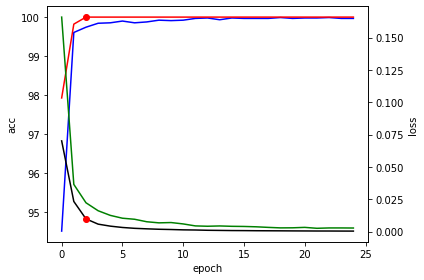

In [11]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
print('Best model valid Acc: %d - %.2f | %.2f | %.2f' %(best_idx, valid_acc[best_idx], valid_f1[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

# For test

In [12]:
# weights_path = 'output/model_2_100.00_100.00.pt'

In [13]:
## load model for test
def load_model_for_test(weights_path):
    
    # load best model from weight
    # weights_path = 'output_crop/model_4_100.00_100.00.pt'


    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    ## load model
    from efficientnet_pytorch import EfficientNet
    model_name = 'efficientnet-b0'  # b5
    num_classes = 2  # 장싱, 비정상
    freeze_extractor = True  # FC layer만 학습하고 efficientNet extractor 부분은 freeze하여 학습시간 단축, 89860 vs 4097408
    use_multi_gpu = True

    model_load = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
    state_dict = torch.load(weights_path, map_location=device)  # load weight
    model_load.load_state_dict(state_dict, strict=False)  # insert weight to model structure

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)            
    print('학습 parameters 개수 : %d'%(count_parameters(model_load)))

    # multi gpu(2개 이상)를 사용하는 경우
    if use_multi_gpu:
        num_gpu = torch.cuda.device_count()
        if (device.type=='cuda') and (num_gpu > 1):
            print('use multi gpu : %d' % (num_gpu))
            model_load = nn.DataParallel(model_load, device_ids=list(range(num_gpu)))

    model_load = model_load.to(device)
    model_load.eval()

    # define optimizer, criterion
    criterion = nn.CrossEntropyLoss()  # 분류이므로 cross entrophy 사용    
    
    return model_load, criterion, device

model_load, criterion, device = load_model_for_test(weights_path)

Loaded pretrained weights for efficientnet-b0
학습 parameters 개수 : 4010110
use multi gpu : 2


test done : loss|acc|f1 : 0.010 | 99.91 | 99.78 


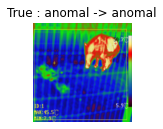

data_220104_split/test/anomal/A02_H20_C050_F_211127_5001_60S_000000.000.jpg


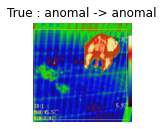

data_220104_split/test/anomal/A02_H20_C050_F_211127_5001_60S_000000.005.jpg


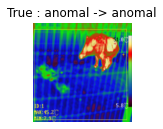

data_220104_split/test/anomal/A02_H20_C050_F_211127_5001_60S_000000.015.jpg


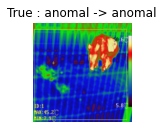

data_220104_split/test/anomal/A02_H20_C050_F_211127_5001_60S_000001.010.jpg


In [14]:
# get_test_metric
def get_test_metric(model, phase = 'test', num_images=4, device='cuda', is_Test=False):

    ## 데이타 체크
    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)  # pause a bit so that plots are updated
        
    class_names = ['anomal', 'normal']
    was_training = model.training
    model.eval()

    running_loss, running_corrects, num_cnt = 0.0, 0, 0
    pred_list, label_list = [], []  


    dataloader = dataloaders[phase]
    allFiles, _ = map(list, zip(*dataloader.dataset.samples))

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(dataloaders[phase]):

            if is_Test:
                if idx > 2: break

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

            pred_list  += preds.data.cpu().numpy().tolist()
            label_list += labels.data.cpu().numpy().tolist()

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt
        test_f1   = float(f1_score(label_list, pred_list, average='macro'))  # micro    
        print('test done : loss|acc|f1 : %.3f | %.2f | %.2f ' % (test_loss, test_acc*100, test_f1*100))
    
    ## 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        
                
            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[int(labels[j].cpu().numpy())]==class_names[int(preds[j].cpu().numpy())] else 'False!!!',
                    class_names[int(labels[j].cpu().numpy())], class_names[int(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])
                print(allFiles[ i * batch_size + j -1])            
            if i == 0 : break

    return label_list, pred_list


## TEST!
label_list, outputs_list = get_test_metric(model=model_load, num_images=4, device=device)


# Done